# Introduction

This dataset consists of various real-valued features computed for each cell nucleus like radius (mean of distances from center to points on the perimeter), texture (standard deviation of gray-scale values), perimeter, area, smoothness (local variation in radius lengths), compactness (perimeter^2 / area - 1.0), concavity (severity of concave portions of the contour), concave points (number of concave portions of the contour), symmetry, fractal dimension ("coastline approximation" - 1) which are used to predict diagnosis of a tumour as M(malignant)or B(benign).

Dataset link: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

Our goal is to take all the features radius, perimeter and so on in the dataset and predict whether the tumour detected on the breast is Benign or Malignant (Binary Classification problem)

In [118]:
import numpy as np
import pandas as pd
import time

%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.linalg import pinv
from numpy import linalg as LA

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_mutual_info_score, mean_squared_error
from sklearn.metrics.cluster import homogeneity_score
from sklearn import mixture
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
data = pd.read_csv('./data/breastcancer.csv')
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [3]:
data.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [4]:
data.describe()

id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  texture_worst  perimeter_worst   area_worst  \
count     569.000000  ...     569.000000       569.000000   569.000000   
mean        0.181162  ...      25.677223       107.261213   880.583128   
std         0.027414  ...       6.146258        33.602542   569.356993   
min         0.106000  ...      12.020000        50.410000   185.200000   
25%         0.161900  ...      21.080000        84.110000   515.300000   
50%         0.179200  ...      25.410000        97.660000   686.500000   
75%         0.195700  ...      29.720000       125.400000  1084.000000   
max         0.304000  ...      49.540000       251.200000  4254.000000   

       smoothness_worst  compactness_worst  concavity_worst  \
count        569.000000         569.000000       569.000000   
mean           0.132369           0.254265         0.272188   
std            0.022832           0.157336         0.208624   
min            0.071170           0.027290         0.000000   
25%            0.116600           0.147200         0.114500   
50%            0.131300           0.211900         0.226700   
75%            0.146000           0.339100         0.382900   
max            0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  \
count            569.000000      569.000000               569.000000   
mean               0.114606        0.290076                 0.083946   
std                0.065732        0.061867                 0.018061   
min                0.000000        0.156500                 0.055040   
25%                0.064930        0.250400                 0.071460   
50%                0.099930        0.282200                 0.080040   
75%                0.161400        0.317900                 0.092080   
max                0.291000        0.663800                 0.207500   

       Unnamed: 32  
count          0.0  
mean           NaN  
std            NaN  
min            NaN  
25%            NaN  
50%            NaN  
75%            NaN  
max            NaN  

[8 rows x 32 columns]

In [5]:
# data preprocessing
data.dropna()
data[data == '?'] = np.NaN
data.isnull().values.any()

True

In [6]:
malignant_cases = data[data['diagnosis'] == "M"] 
benign_cases = data[data['diagnosis'] == "B"] 
print("MALIGNANT CASES = " + str(len(malignant_cases)))
print("BENIGN CASES = " + str(len(benign_cases)))
print("% of Malignant cases = " + str((len(malignant_cases)/(len(malignant_cases)+len(benign_cases)))*100))

MALIGNANT CASES = 212
BENIGN CASES = 357
% of Malignant cases = 37.258347978910365


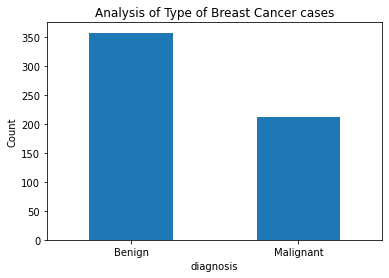

<Figure size 432x288 with 0 Axes>

In [7]:
labels = ["Benign","Malignant"]
count_classes = data.value_counts(data['diagnosis'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Analysis of Type of Breast Cancer cases")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()
plt.savefig(f"./images/BreastCancerClasses.png")

In [8]:
# Standardization of features
df_pd = pd.read_csv("./data/breastcancer.csv")
df_pd.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
X = df_pd
y = df_pd['diagnosis']
le = LabelEncoder()
X['diagnosis'] = le.fit_transform(X['diagnosis'])
y = le.transform(y)

In [9]:
X.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [10]:
# Feature Scaling
cols = X.columns
ms = MinMaxScaler()
X = ms.fit_transform(X)
X = pd.DataFrame(X, columns=[cols])

In [11]:
X.head()

diagnosis radius_mean texture_mean perimeter_mean area_mean smoothness_mean  \
0       1.0    0.521037     0.022658       0.545989  0.363733        0.593753   
1       1.0    0.643144     0.272574       0.615783  0.501591        0.289880   
2       1.0    0.601496     0.390260       0.595743  0.449417        0.514309   
3       1.0    0.210090     0.360839       0.233501  0.102906        0.811321   
4       1.0    0.629893     0.156578       0.630986  0.489290        0.430351   

  compactness_mean concavity_mean concave points_mean symmetry_mean  ...  \
0         0.792037       0.703140            0.731113      0.686364  ...   
1         0.181768       0.203608            0.348757      0.379798  ...   
2         0.431017       0.462512            0.635686      0.509596  ...   
3         0.811361       0.565604            0.522863      0.776263  ...   
4         0.347893       0.463918            0.518390      0.378283  ...   

  radius_worst texture_worst perimeter_worst area_worst smoothness_worst  \
0     0.620776      0.141525        0.668310   0.450698         0.601136   
1     0.606901      0.303571        0.539818   0.435214         0.347553   
2     0.556386      0.360075        0.508442   0.374508         0.483590   
3     0.248310      0.385928        0.241347   0.094008         0.915472   
4     0.519744      0.123934        0.506948   0.341575         0.437364   

  compactness_worst concavity_worst concave points_worst symmetry_worst  \
0          0.619292        0.568610             0.912027       0.598462   
1          0.154563        0.192971             0.639175       0.233590   
2          0.385375        0.359744             0.835052       0.403706   
3          0.814012        0.548642             0.884880       1.000000   
4          0.172415        0.319489             0.558419       0.157500   

  fractal_dimension_worst  
0                0.418864  
1                0.222878  
2                0.213433  
3                0.773711  
4                0.142595  

[5 rows x 31 columns]

# K-Means Clustering

In [12]:
inertia = []
k_val = []
accuracy = []
for k in range(1,50):
    kmeans = KMeans(n_clusters=k, random_state=0) 
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    k_val.append(k)
    labels = kmeans.labels_
    correct_labels = sum(y == labels)
    acc = correct_labels/float(y.size)
    accuracy.append(acc)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.wa

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.wa

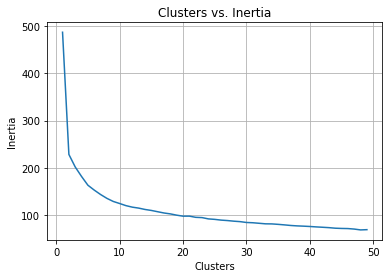

In [13]:
plt.plot(k_val,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia')
plt.grid()
plt.savefig('./images/kmeans_clusters_vs_inertia.png')
plt.show()

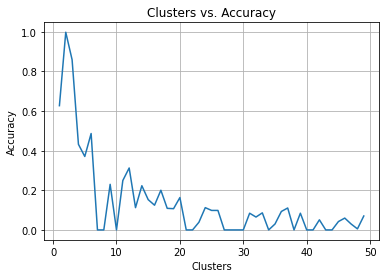

In [14]:
plt.plot(k_val,accuracy)
plt.xlabel('Clusters')
plt.ylabel('Accuracy')
plt.title('Clusters vs. Accuracy')
plt.grid()
plt.savefig('./images/bc_kmeans_clusters_vs_accuracy.png')
plt.show()

For K=2 we observed 99.8% accuracy and K=3 we observed 85.94% accuracy on breast cancer dataset

Now we will use Elbow method to find the optimal value for number of clusters K

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.wa

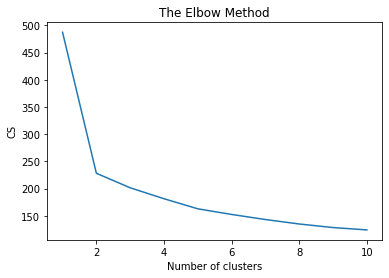

In [15]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.savefig('./images/bc_kmeans_elbow_method.png')
plt.show()

From the above graph, we can clearly see there is a kink at K=2, Hence k=2 can be considered a good number of the cluster to cluster this data.

In [16]:
kmeans = KMeans(n_clusters=2,random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 568 out of 569 samples were correctly labeled.
Accuracy score: 1.00


/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


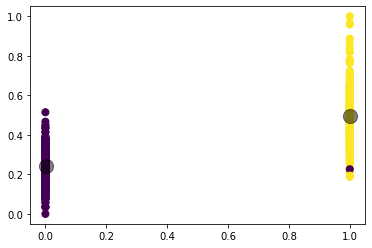

In [17]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.savefig('./images/bc_kmeans_clusters.png')

# Expectation Maximization (EM)

In [19]:
#reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def get_kmeans_elbow(X, title):
    clusters = [x for x in range(2,10)]
    sil_scores = {}
    for cluster in tqdm(clusters):
        clusterer = KMeans(n_clusters=cluster, random_state=27)
        cluster_labels = clusterer.fit_predict(X)
        sil_score = silhouette_score(X, cluster_labels)
        sil_scores[cluster] = sil_score
    plt.plot(sil_scores.keys(), sil_scores.values(), label="kmeans")
    
    sil_scores = {}
    for cluster in tqdm(clusters):
        clusterer = GaussianMixture(n_components=cluster, random_state=27, reg_covar=1e-4)
        cluster_labels = clusterer.fit_predict(X)
        sil_score = silhouette_score(X, cluster_labels)
        sil_scores[cluster] = sil_score
    plt.plot(sil_scores.keys(), sil_scores.values(), label="gmm")
    plt.xlabel("No. of clusters")
    plt.ylabel("Silhoutte Coefficient")
    plt.title(title)
    plt.legend()
    plt.savefig('./images/Silhoutte_Coefficient_vs_K_for_Breast_cancer_dataset.png')
    plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.wa

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.wa

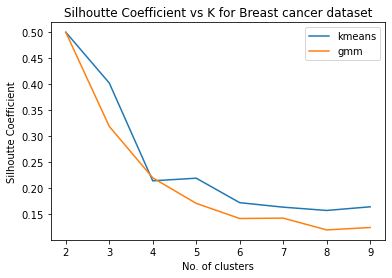

In [20]:
get_kmeans_elbow(X, "Silhoutte Coefficient vs K for Breast cancer dataset")

In [21]:
homogeneity_score(KMeans(n_clusters=2, random_state=0).fit_predict(X), y)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.9830642132394729

In [22]:
homogeneity_score(GaussianMixture(n_components=2, random_state=0, reg_covar=1e-4).fit_predict(X), y)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


1.0

In [23]:
data_with_clusters = df_pd
data_with_clusters["cluster"] = KMeans(n_clusters=2, random_state=0).fit_predict(X)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [24]:
data_with_clusters.corr()["cluster"].abs().sort_values().index[-50:]

Index(['symmetry_se', 'fractal_dimension_mean', 'texture_se', 'smoothness_se',
       'fractal_dimension_se', 'concavity_se', 'compactness_se',
       'fractal_dimension_worst', 'symmetry_mean', 'smoothness_mean',
       'concave points_se', 'texture_mean', 'symmetry_worst',
       'smoothness_worst', 'texture_worst', 'area_se', 'perimeter_se',
       'radius_se', 'compactness_worst', 'compactness_mean', 'concavity_worst',
       'concavity_mean', 'area_mean', 'radius_mean', 'area_worst',
       'perimeter_mean', 'concave points_mean', 'radius_worst',
       'perimeter_worst', 'concave points_worst', 'diagnosis', 'cluster'],
      dtype='object')

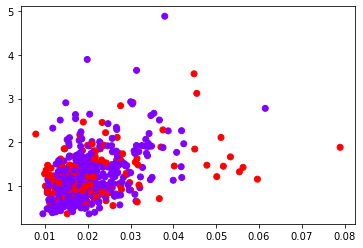

In [25]:
plt.scatter(data_with_clusters['symmetry_se'],data_with_clusters['texture_se'],c=data_with_clusters['cluster'],cmap='rainbow')
plt.savefig('./images/bc_kmeans_clusters1.png')

In [26]:
import plotly.express as px
fig = px.scatter_3d(df_pd, x='symmetry_se', y='symmetry_worst', z='diagnosis',
              color='cluster')
fig.show()
plt.savefig('./images/bc_kmeans_clusters_3d.png')

<Figure size 432x288 with 0 Axes>

# Dimensionality Reduction

PCA (Principal component analysis)

ICA (Independent component analysis)

RP (Randomized Projections)

LDA (LinearDiscriminantAnalysis)

# PCA

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/

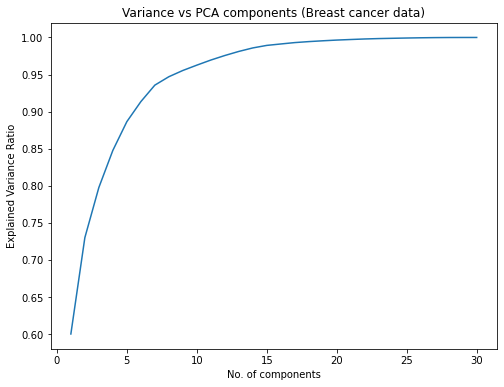

<Figure size 576x432 with 0 Axes>

In [27]:
exp = {}
plt.rcParams["figure.figsize"] = (8,6)
for i in range(1, 31):
    pca = PCA(n_components=i)
    pca.fit(X)
    exp[i] = sum(pca.explained_variance_ratio_)
plt.plot(exp.keys(), exp.values())
plt.xlabel("No. of components")
plt.ylabel("Explained Variance Ratio")
plt.title("Variance vs PCA components (Breast cancer data)")
plt.show()
plt.savefig('./images/bc_variance_vs_pca_components.png')

In [28]:
pca = PCA(n_components=5)
X_PCA = pca.fit_transform(X)
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.3, random_state=0)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [29]:
x_pca = pd.DataFrame(X_PCA)

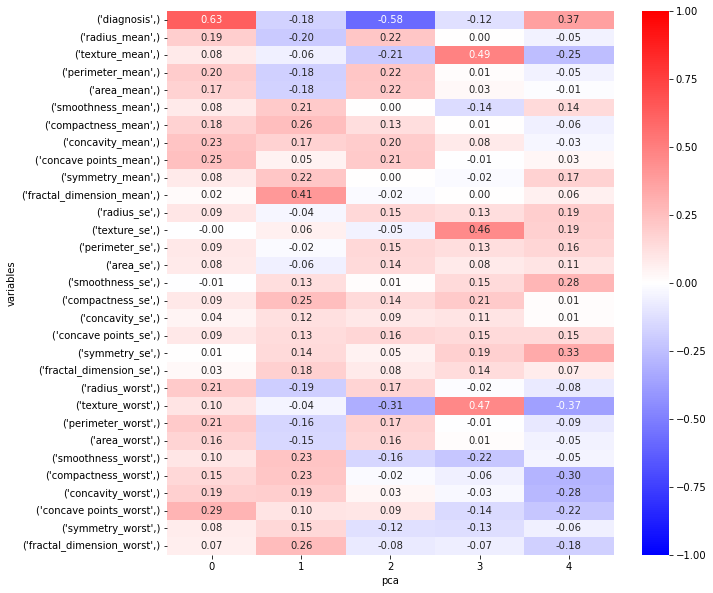

In [31]:
# Visualization by heatmap
plt.figure(figsize=(10,10))
hm = sns.heatmap(pca.components_.T, cbar=True, annot=True, cmap='bwr', fmt=".2f", 
                 annot_kws={"size":10}, yticklabels=X.columns.tolist(), xticklabels=x_pca.columns, vmax=1, vmin=-1, center=0)
plt.xlabel("pca")
plt.ylabel("variables")
plt.savefig('./images/bc_pcs_heatmap.png')

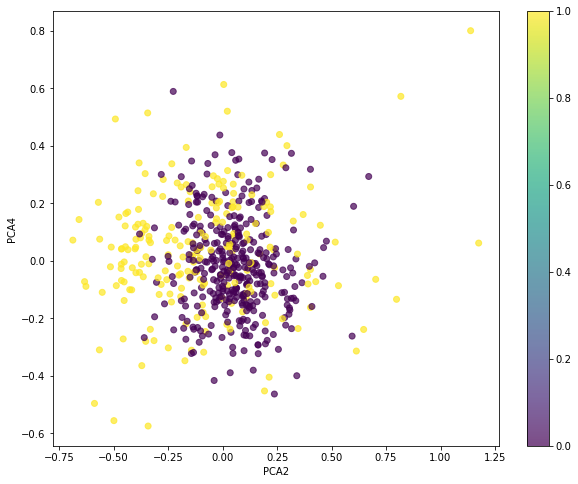

In [32]:
# visualization by plot
x1 = x_pca[2]
y1 = x_pca[4]
c = y

plt.figure(figsize=(10,8))
plt.scatter(x1, y1, c=c, alpha=0.7)
plt.xlabel("PCA2")
plt.ylabel("PCA4")
plt.colorbar()
plt.savefig('./images/bc_pca_scatter_plot.png')

# ICA

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/

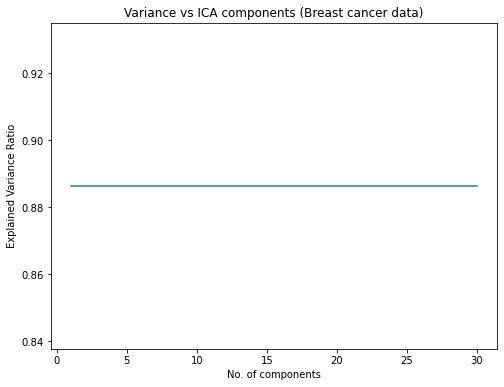

<Figure size 576x432 with 0 Axes>

In [33]:
exp = {}
plt.rcParams["figure.figsize"] = (8,6)
for i in range(1, 31):
    ica = FastICA(n_components=i)
    ica.fit(X)
    exp[i] = sum(pca.explained_variance_ratio_)
plt.plot(exp.keys(), exp.values())
plt.xlabel("No. of components")
plt.ylabel("Explained Variance Ratio")
plt.title("Variance vs ICA components (Breast cancer data)")
plt.show()
plt.savefig('./images/bc_variance_vs_ica_components.png')

In [34]:
ica = FastICA(n_components=5)
X_ICA = ica.fit_transform(X)
X_ICA_train, X_ICA_test, y_ICA_train, y_ICA_test = train_test_split(X_ICA, y, test_size=0.3, random_state=0)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [35]:
x_ica = pd.DataFrame(X_ICA)

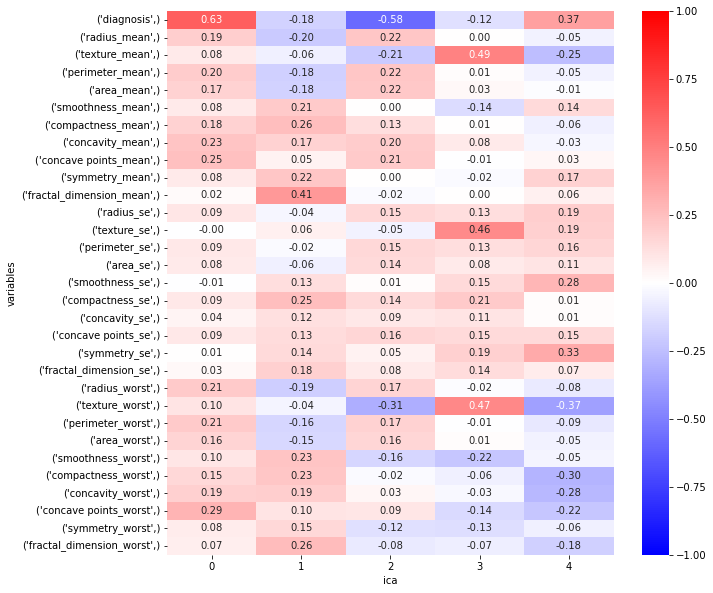

In [36]:
# Visualization by heatmap
plt.figure(figsize=(10,10))
hm = sns.heatmap(pca.components_.T, cbar=True, annot=True, cmap='bwr', fmt=".2f", 
                 annot_kws={"size":10}, yticklabels=X.columns.tolist(), xticklabels=x_ica.columns, vmax=1, vmin=-1, center=0)
plt.xlabel("ica")
plt.ylabel("variables")
plt.savefig('./images/bc_ica_heatmap.png')

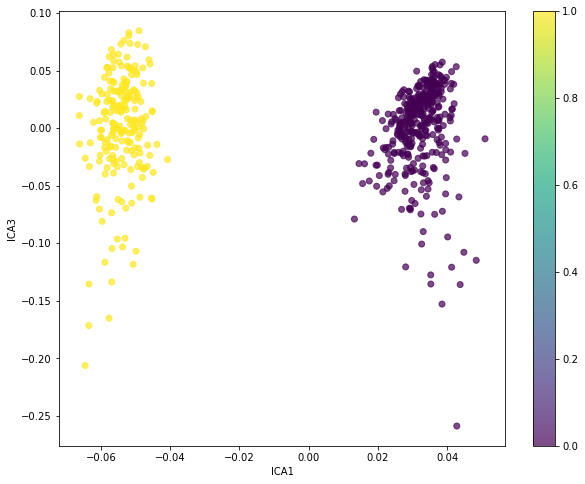

In [39]:
# visualization by plot
x2 = x_ica[1]
y2 = x_ica[3]
c = y

plt.figure(figsize=(10,8))
plt.scatter(x2, y2, c=c, alpha=0.7)
plt.xlabel("ICA1")
plt.ylabel("ICA3")
plt.colorbar()
plt.savefig('./images/bc_ica_scatter_plot.png')

# RP

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/

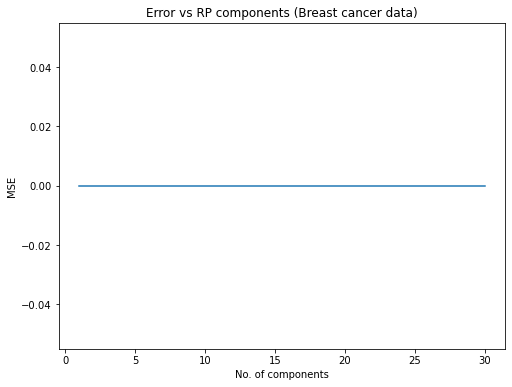

<Figure size 576x432 with 0 Axes>

In [44]:
exp = {}
plt.rcParams["figure.figsize"] = (8,6)
for i in range(1, 31):
    rp = GaussianRandomProjection(n_components=i)
    rp.fit(X)
    w = rp.components_
    p = pinv(w)
    reconstructed = ((p@w)@(X.T)).T
    exp[i] = np.std(mean_squared_error(X,reconstructed))
plt.plot(exp.keys(), exp.values())
plt.xlabel("No. of components")
plt.ylabel("MSE")
plt.title("Error vs RP components (Breast cancer data)")
plt.show()
plt.savefig('./images/bc_mse_vs_rp_components.png')

In [45]:
rp = GaussianRandomProjection(n_components=5)
X_RP = rp.fit_transform(X)
X_RP_train, X_RP_test, y_RP_train, y_RP_test = train_test_split(X_RP, y, test_size=0.3, random_state=0)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [47]:
x_rp = pd.DataFrame(X_RP)

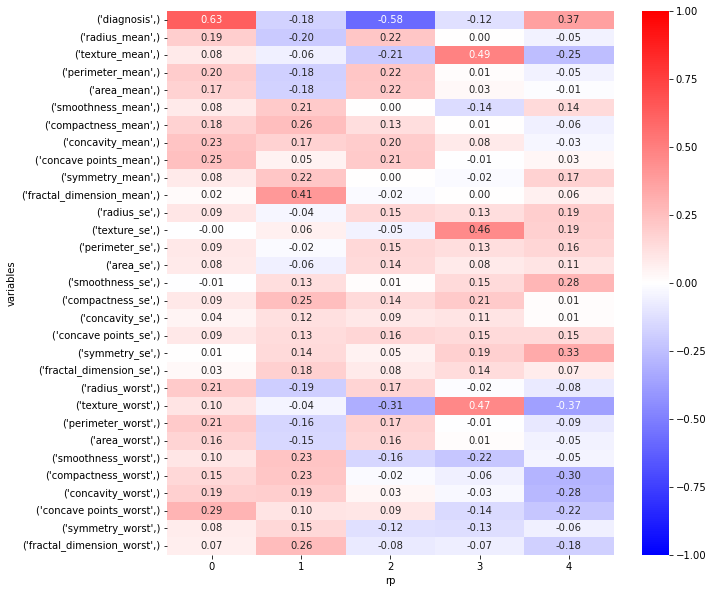

In [48]:
# Visualization by heatmap
plt.figure(figsize=(10,10))
hm = sns.heatmap(pca.components_.T, cbar=True, annot=True, cmap='bwr', fmt=".2f", 
                 annot_kws={"size":10}, yticklabels=X.columns.tolist(), xticklabels=x_rp.columns, vmax=1, vmin=-1, center=0)
plt.xlabel("rp")
plt.ylabel("variables")
plt.savefig('./images/bc_rp_heatmap.png')

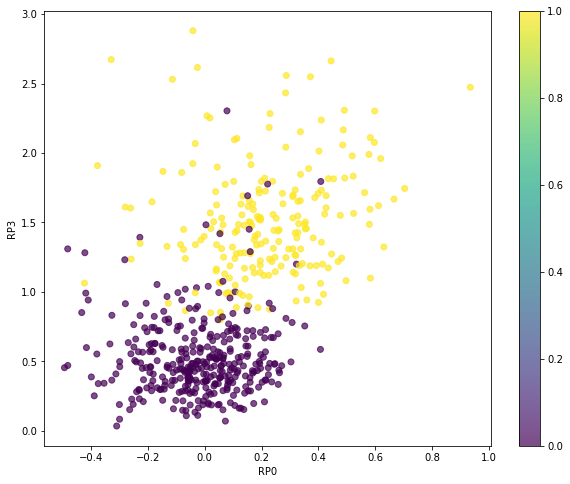

In [49]:
# visualization by plot
x3 = x_rp[0]
y3 = x_rp[3]
c = y

plt.figure(figsize=(10,8))
plt.scatter(x3, y3, c=c, alpha=0.7)
plt.xlabel("RP0")
plt.ylabel("RP3")
plt.colorbar()
plt.savefig('./images/bc_rp_scatter_plot.png')

# LDA

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/

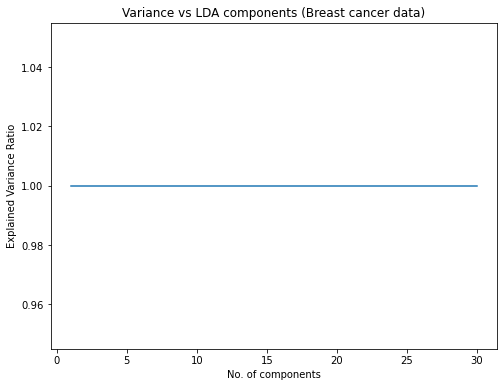

<Figure size 576x432 with 0 Axes>

In [52]:
exp = {}
plt.rcParams["figure.figsize"] = (8,6)
for i in range(1, 31):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X,y)
    exp[i] = sum(lda.explained_variance_ratio_)
plt.plot(exp.keys(), exp.values())
plt.xlabel("No. of components")
plt.ylabel("Explained Variance Ratio")
plt.title("Variance vs LDA components (Breast cancer data)")
plt.show()
plt.savefig('./images/bc_variance_vs_lda_components.png')

In [55]:
lda = LinearDiscriminantAnalysis()
X_LDA = lda.fit_transform(X,y)
X_LDA_train, X_LDA_test, y_LDA_train, y_LDA_test = train_test_split(X_LDA, y, test_size=0.3, random_state=0)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [56]:
x_lda = pd.DataFrame(X_LDA)

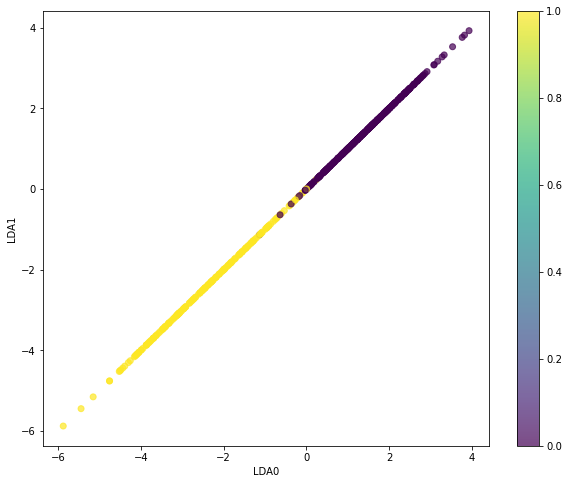

In [58]:
# visualization by plot
x4 = x_lda[0]
y4 = x_lda[0]
c = y

plt.figure(figsize=(10,8))
plt.scatter(x4, y4, c=c, alpha=0.7)
plt.xlabel("LDA0")
plt.ylabel("LDA1")
plt.colorbar()
plt.savefig('./images/bc_lda_scatter_plot.png')

# Clustering on Dimensionally Reduced Data

# K Means on PCA Data

In [62]:
inertia_pca = []
k_val_pca = []
accuracy_pca = []
for k in range(1,50):
    kmeans_pca = KMeans(n_clusters=k, random_state=0) 
    kmeans_pca.fit(X_PCA)
    inertia_pca.append(kmeans_pca.inertia_)
    k_val_pca.append(k)
    labels_pca = kmeans_pca.labels_
    correct_labels = sum(y == labels_pca)
    acc = correct_labels/float(y.size)
    accuracy_pca.append(acc)

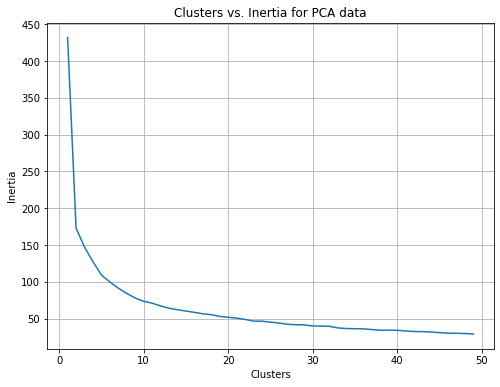

In [63]:
plt.plot(k_val_pca,inertia_pca)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for PCA data')
plt.grid()
plt.savefig('./images/kmeans_clusters_vs_inertia_pca.png')
plt.show()

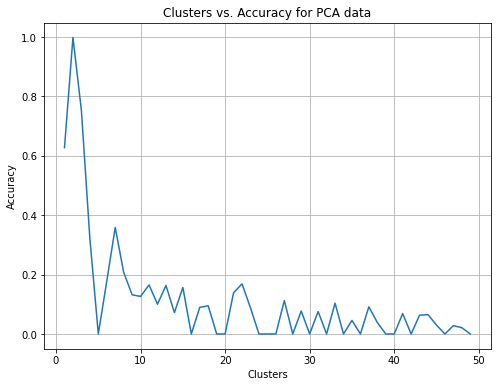

In [64]:
plt.plot(k_val_pca,accuracy_pca)
plt.xlabel('Clusters')
plt.ylabel('Accuracy')
plt.title('Clusters vs. Accuracy for PCA data')
plt.grid()
plt.savefig('./images/bc_kmeans_clusters_vs_accuracy_pca.png')
plt.show()

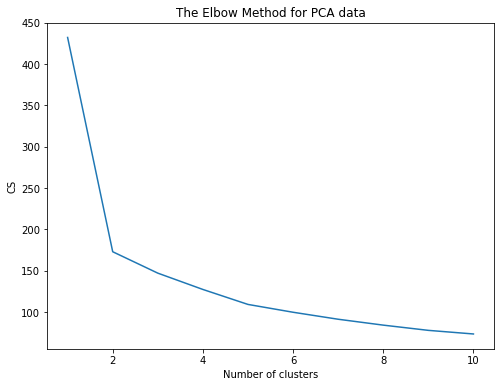

In [66]:
cs = []
for i in range(1, 11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_pca.fit(X_PCA)
    cs.append(kmeans_pca.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method for PCA data')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.savefig('./images/bc_kmeans_elbow_method_pca.png')
plt.show()

In [68]:
kmeans_PCA = KMeans(n_clusters=2,random_state=0)
kmeans_PCA.fit(X_PCA)
y_kmeans_PCA = kmeans_PCA.predict(X_PCA)
labels_PCA = kmeans_PCA.labels_
centers_PCA = kmeans_PCA.cluster_centers_
# check how many of the samples were correctly labeled
correct_labels_PCA = sum(y == labels_PCA)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_PCA, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_PCA/float(y.size)))

Result: 568 out of 569 samples were correctly labeled.
Accuracy score: 1.00


# K Means on ICA Data

In [69]:
inertia_ica = []
k_val_ica = []
accuracy_ica = []
for k in range(1,50):
    kmeans_ica = KMeans(n_clusters=k, random_state=0) 
    kmeans_ica.fit(X_ICA)
    inertia_ica.append(kmeans_ica.inertia_)
    k_val_ica.append(k)
    labels_ica = kmeans_ica.labels_
    correct_labels = sum(y == labels_ica)
    acc = correct_labels/float(y.size)
    accuracy_ica.append(acc)

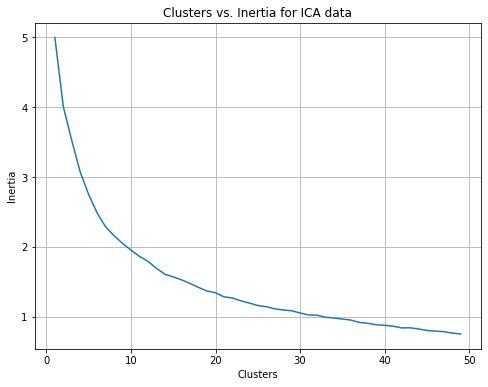

In [70]:
plt.plot(k_val_ica,inertia_ica)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for ICA data')
plt.grid()
plt.savefig('./images/kmeans_clusters_vs_inertia_ica.png')
plt.show()

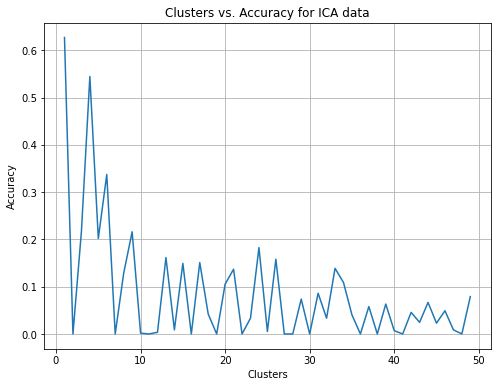

In [71]:
plt.plot(k_val_ica,accuracy_ica)
plt.xlabel('Clusters')
plt.ylabel('Accuracy')
plt.title('Clusters vs. Accuracy for ICA data')
plt.grid()
plt.savefig('./images/bc_kmeans_clusters_vs_accuracy_Ica.png')
plt.show()

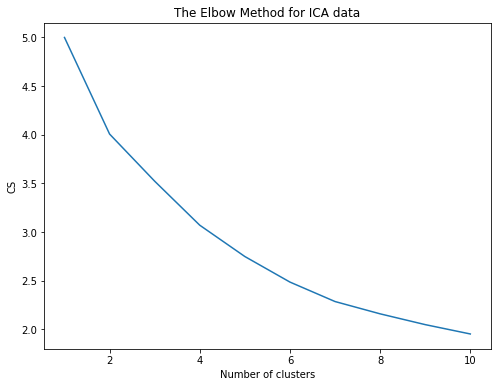

In [72]:
cs = []
for i in range(1, 11):
    kmeans_ica = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_ica.fit(X_ICA)
    cs.append(kmeans_ica.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method for ICA data')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.savefig('./images/bc_kmeans_elbow_method_ica.png')
plt.show()

In [73]:
kmeans_ICA = KMeans(n_clusters=2,random_state=0)
kmeans_ICA.fit(X_ICA)
y_kmeans_ICA = kmeans_ICA.predict(X_ICA)
labels_ICA = kmeans_ICA.labels_
centers_ICA = kmeans_ICA.cluster_centers_
# check how many of the samples were correctly labeled
correct_labels_ICA = sum(y == labels_ICA)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_ICA, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_ICA/float(y.size)))

Result: 0 out of 569 samples were correctly labeled.
Accuracy score: 0.00


# K Means on RP data

In [74]:
inertia_rp = []
k_val_rp = []
accuracy_rp = []
for k in range(1,50):
    kmeans_rp = KMeans(n_clusters=k, random_state=0) 
    kmeans_rp.fit(X_RP)
    inertia_rp.append(kmeans_rp.inertia_)
    k_val_rp.append(k)
    labels_rp = kmeans_rp.labels_
    correct_labels = sum(y == labels_rp)
    acc = correct_labels/float(y.size)
    accuracy_rp.append(acc)

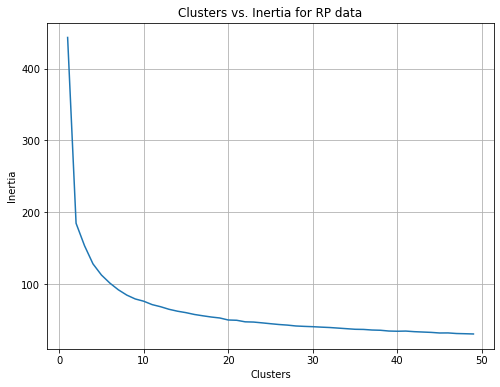

In [75]:
plt.plot(k_val_rp,inertia_rp)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RP data')
plt.grid()
plt.savefig('./images/kmeans_clusters_vs_inertia_rp.png')
plt.show()

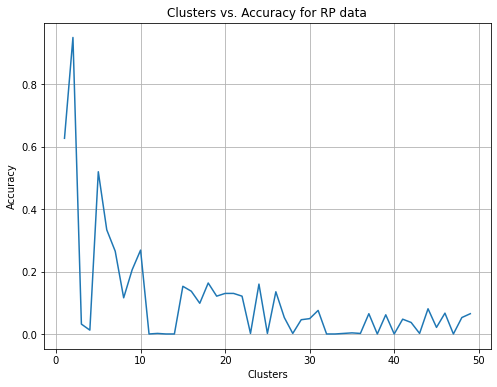

In [76]:
plt.plot(k_val_rp,accuracy_rp)
plt.xlabel('Clusters')
plt.ylabel('Accuracy')
plt.title('Clusters vs. Accuracy for RP data')
plt.grid()
plt.savefig('./images/bc_kmeans_clusters_vs_accuracy_rp.png')
plt.show()

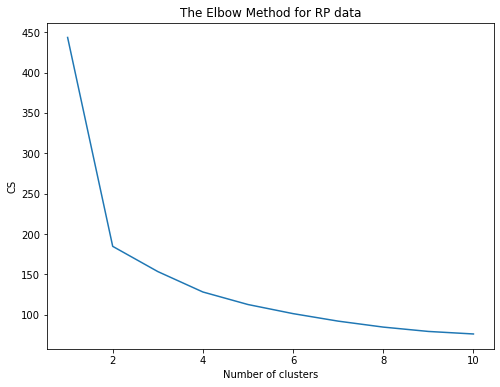

In [77]:
cs = []
for i in range(1, 11):
    kmeans_rp = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_rp.fit(X_RP)
    cs.append(kmeans_rp.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method for RP data')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.savefig('./images/bc_kmeans_elbow_method_rp.png')
plt.show()

In [78]:
kmeans_RP = KMeans(n_clusters=2,random_state=0)
kmeans_RP.fit(X_RP)
y_kmeans_RP = kmeans_RP.predict(X_RP)
labels_RP = kmeans_RP.labels_
centers_RP = kmeans_RP.cluster_centers_
# check how many of the samples were correctly labeled
correct_labels_RP = sum(y == labels_RP)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_RP, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_RP/float(y.size)))

Result: 541 out of 569 samples were correctly labeled.
Accuracy score: 0.95


# K Means on LDA Data

In [79]:
inertia_lda = []
k_val_lda = []
accuracy_lda = []
for k in range(1,50):
    kmeans_lda = KMeans(n_clusters=k, random_state=0) 
    kmeans_lda.fit(X_LDA)
    inertia_lda.append(kmeans_lda.inertia_)
    k_val_lda.append(k)
    labels_lda = kmeans_lda.labels_
    correct_labels = sum(y == labels_lda)
    acc = correct_labels/float(y.size)
    accuracy_lda.append(acc)

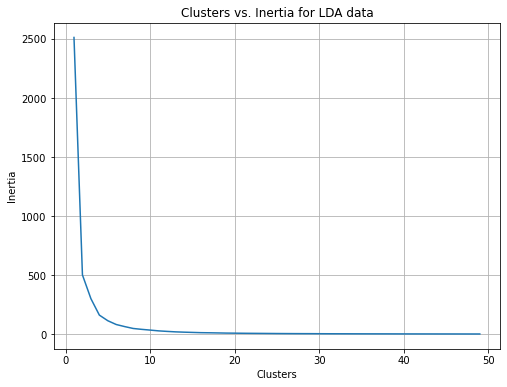

In [80]:
plt.plot(k_val_lda,inertia_lda)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for LDA data')
plt.grid()
plt.savefig('./images/kmeans_clusters_vs_inertia_lda.png')
plt.show()

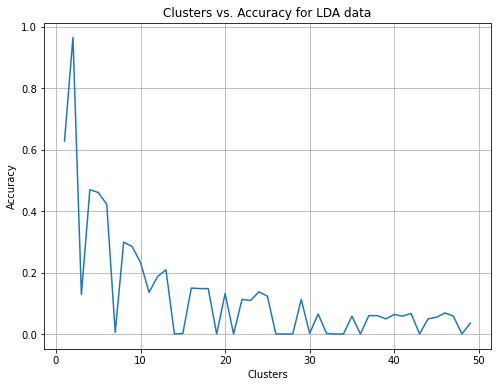

In [81]:
plt.plot(k_val_lda,accuracy_lda)
plt.xlabel('Clusters')
plt.ylabel('Accuracy')
plt.title('Clusters vs. Accuracy for LDA data')
plt.grid()
plt.savefig('./images/bc_kmeans_clusters_vs_accuracy_lda.png')
plt.show()

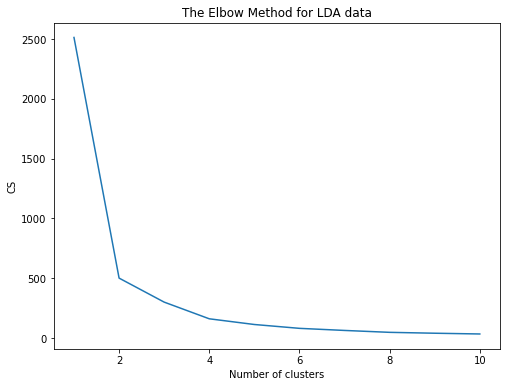

In [82]:
cs = []
for i in range(1, 11):
    kmeans_lda = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_lda.fit(X_LDA)
    cs.append(kmeans_lda.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method for LDA data')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.savefig('./images/bc_kmeans_elbow_method_lda.png')
plt.show()

In [83]:
kmeans_LDA = KMeans(n_clusters=2,random_state=0)
kmeans_LDA.fit(X_LDA)
y_kmeans_LDA = kmeans_LDA.predict(X_LDA)
labels_LDA = kmeans_LDA.labels_
centers_LDA = kmeans_LDA.cluster_centers_
# check how many of the samples were correctly labeled
correct_labels_LDA = sum(y == labels_LDA)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_LDA, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_LDA/float(y.size)))

Result: 549 out of 569 samples were correctly labeled.
Accuracy score: 0.96


# Neural Networks on Dimensionally Reduced data

First we will apply Neural Networks on original breast cancer dataset to check its performance

In [88]:
start_time = time.time()
mlp = MLPClassifier(
    max_iter=1000,
    alpha=0.1,
    activation='logistic',
    solver='adam',
    random_state=42
)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)
mlp.fit(X_train, y_train)

mlp_predict = mlp.predict(X_test)
mlp_predict_proba = mlp.predict_proba(X_test)[:, 1]
end_time = time.time()
time_infer = end_time-start_time

print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_test, mlp_predict) * 100))
print('MLP AUC: {:.2f}%'.format(roc_auc_score(y_test, mlp_predict_proba) * 100))
print('MLP Classification report:\n\n', classification_report(y_test, mlp_predict))
print('MLP Training set score: {:.2f}%'.format(mlp.score(X_train, y_train) * 100))
print('MLP Testing set score: {:.2f}%'.format(mlp.score(X_test, y_test) * 100))
print("Inference Time:",time_infer)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



MLP Accuracy: 100.00%
MLP AUC: 100.00%
MLP Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        70

    accuracy                           1.00       188
   macro avg       1.00      1.00      1.00       188
weighted avg       1.00      1.00      1.00       188

MLP Training set score: 100.00%
MLP Testing set score: 100.00%
Inference Time: 0.9218108654022217


/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [89]:
# utils
def evaluation_metrics(y_test, y_pred, model):
    n_errors = (y_pred != y_test).sum() 
    print("The model used is " + str(model)) 
    acc = accuracy_score(y_test, y_pred) 
    print("The accuracy is {}".format(acc)) 
    prec = precision_score(y_test, y_pred) 
    print("The precision is {}".format(prec)) 
    rec = recall_score(y_test, y_pred) 
    print("The recall is {}".format(rec)) 
    f1 = f1_score(y_test, y_pred) 
    print("The F1-Score is {}".format(f1)) 
    MCC = matthews_corrcoef(y_test, y_pred) 
    print("The Matthews correlation coefficient is {}".format(MCC)) 
    AUC = roc_auc_score(y_test, y_pred)
    print("The ROC-AUC Score is {}".format(AUC)) 
    
def plot_confusion_matrix(y_test, y_pred, model,dataset):
    class_labels = ["Benign","Malignant"] 
    conf_matrix = confusion_matrix(y_test, y_pred) 
    plt.figure(figsize =(5, 5)) 
    sns.heatmap(conf_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, fmt ="d"); 
    plt.title("Confusion matrix of " + str(model)) 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    #plt.show() 
    plt.savefig(f"./images/" + dataset + "_" + str(model) + ".png")

The model used is MultiLayerPerceptronClassification
The accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1-Score is 1.0
The Matthews correlation coefficient is 1.0
The ROC-AUC Score is 1.0


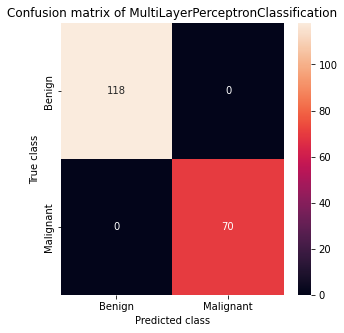

In [91]:
y_pred = mlp_predict
evaluation_metrics(y_test,y_pred,"MultiLayerPerceptronClassification")
plot_confusion_matrix(y_test,y_pred,"MultiLayerPerceptronClassification","breastcancer")

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/

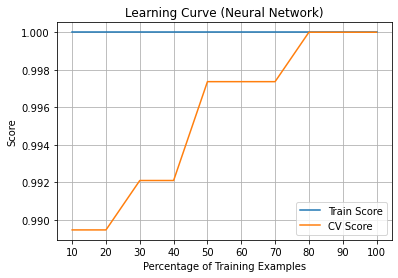

In [94]:
# Learning Curve
classifier_neural_network_learning = mlp
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('./images/bc_neural_network_learning_curve.png')
plt.show()

# MLP on PCA data

In [96]:
start_time = time.time()
mlp_pca = MLPClassifier(
    max_iter=1000,
    alpha=0.1,
    activation='logistic',
    solver='adam',
    random_state=42
)

mlp_pca.fit(X_PCA_train, y_PCA_train)

mlp_predict_pca = mlp_pca.predict(X_PCA_test)
mlp_predict_proba_pca = mlp_pca.predict_proba(X_PCA_test)[:, 1]
end_time = time.time()
time_infer = end_time-start_time

print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_PCA_test, mlp_predict_pca) * 100))
print('MLP AUC: {:.2f}%'.format(roc_auc_score(y_PCA_test, mlp_predict_proba_pca) * 100))
print('MLP Classification report:\n\n', classification_report(y_PCA_test, mlp_predict_pca))
#print('MLP Training set score: {:.2f}%'.format(mlp.score(X_PCA_train, y_PCA_train) * 100))
#print('MLP Testing set score: {:.2f}%'.format(mlp.score(X_PCA_test, y_PCA_test) * 100))
print("Inference Time:",time_infer)

MLP Accuracy: 100.00%
MLP AUC: 100.00%
MLP Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        63

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171

Inference Time: 0.6739060878753662


The model used is MultiLayerPerceptronClassification
The accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1-Score is 1.0
The Matthews correlation coefficient is 1.0
The ROC-AUC Score is 1.0


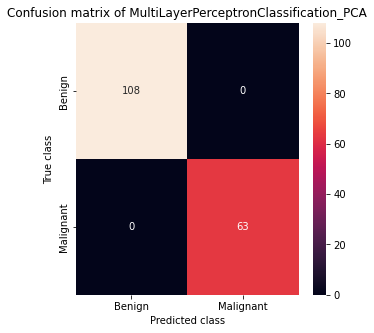

In [100]:
y_pred_mlp_pca = mlp_predict_pca
evaluation_metrics(y_PCA_test,y_pred_mlp_pca,"MultiLayerPerceptronClassification")
plot_confusion_matrix(y_PCA_test,y_pred_mlp_pca,"MultiLayerPerceptronClassification_PCA","breastcancer")

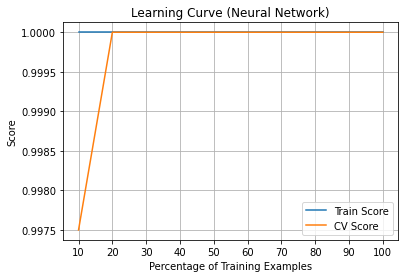

In [103]:
# Learning Curve
classifier_neural_network_learning_pca = mlp_pca
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning_pca, X_PCA_train, y_PCA_train, 
                                              train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('./images/bc_neural_network_learning_curve_pca.png')
plt.show()

# MLP on ICA data

In [99]:
start_time = time.time()
mlp_ica = MLPClassifier(
    max_iter=1000,
    alpha=0.1,
    activation='logistic',
    solver='adam',
    random_state=42
)

mlp_ica.fit(X_ICA_train, y_ICA_train)

mlp_predict_ica = mlp_ica.predict(X_ICA_test)
mlp_predict_proba_ica = mlp_ica.predict_proba(X_ICA_test)[:, 1]
end_time = time.time()
time_infer = end_time-start_time

print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_ICA_test, mlp_predict_ica) * 100))
print('MLP AUC: {:.2f}%'.format(roc_auc_score(y_ICA_test, mlp_predict_proba_ica) * 100))
print('MLP Classification report:\n\n', classification_report(y_ICA_test, mlp_predict_ica))
#print('MLP Training set score: {:.2f}%'.format(mlp.score(X_ICA_train, y_ICA_train) * 100))
#print('MLP Testing set score: {:.2f}%'.format(mlp.score(X_ICA_test, y_ICA_test) * 100))
print("Inference Time:",time_infer)

MLP Accuracy: 100.00%
MLP AUC: 100.00%
MLP Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        63

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171

Inference Time: 1.8737189769744873


/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



The model used is MultiLayerPerceptronClassification
The accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1-Score is 1.0
The Matthews correlation coefficient is 1.0
The ROC-AUC Score is 1.0


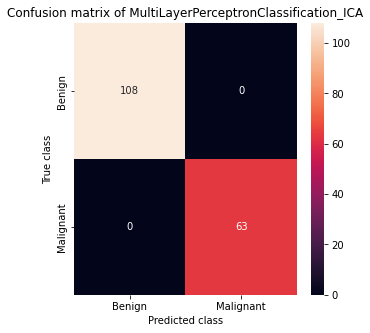

In [101]:
y_pred_mlp_ica = mlp_predict_ica
evaluation_metrics(y_ICA_test,y_pred_mlp_ica,"MultiLayerPerceptronClassification")
plot_confusion_matrix(y_ICA_test,y_pred_mlp_ica,"MultiLayerPerceptronClassification_ICA","breastcancer")

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



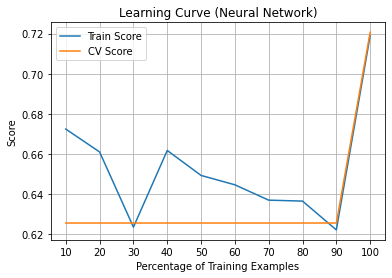

In [104]:
# Learning Curve
classifier_neural_network_learning_ica = mlp_ica
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning_ica, X_ICA_train, y_ICA_train, 
                                              train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('./images/bc_neural_network_learning_curve_ica.png')
plt.show()

# MLP on RP data

In [105]:
start_time = time.time()
mlp_rp = MLPClassifier(
    max_iter=1000,
    alpha=0.1,
    activation='logistic',
    solver='adam',
    random_state=42
)

mlp_rp.fit(X_RP_train, y_RP_train)

mlp_predict_rp = mlp_rp.predict(X_RP_test)
mlp_predict_proba_rp = mlp_rp.predict_proba(X_RP_test)[:, 1]
end_time = time.time()
time_infer = end_time-start_time

print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_RP_test, mlp_predict_rp) * 100))
print('MLP AUC: {:.2f}%'.format(roc_auc_score(y_RP_test, mlp_predict_proba_rp) * 100))
print('MLP Classification report:\n\n', classification_report(y_RP_test, mlp_predict_rp))
#print('MLP Training set score: {:.2f}%'.format(mlp.score(X_RP_train, y_RP_train) * 100))
#print('MLP Testing set score: {:.2f}%'.format(mlp.score(X_RP_test, y_RP_test) * 100))
print("Inference Time:",time_infer)

MLP Accuracy: 98.25%
MLP AUC: 99.24%
MLP Classification report:

               precision    recall  f1-score   support

           0       0.99      0.98      0.99       108
           1       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Inference Time: 0.8374207019805908


The model used is MultiLayerPerceptronClassification
The accuracy is 0.9824561403508771
The precision is 0.96875
The recall is 0.9841269841269841
The F1-Score is 0.9763779527559054
The Matthews correlation coefficient is 0.9625013365574847
The ROC-AUC Score is 0.9828042328042329


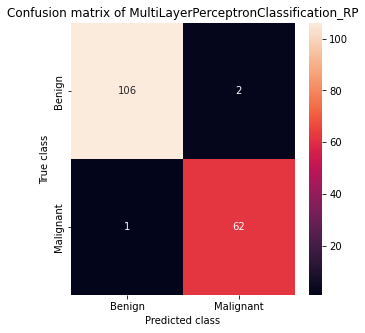

In [106]:
y_pred_mlp_rp = mlp_predict_rp
evaluation_metrics(y_RP_test,y_pred_mlp_rp,"MultiLayerPerceptronClassification")
plot_confusion_matrix(y_RP_test,y_pred_mlp_rp,"MultiLayerPerceptronClassification_RP","breastcancer")

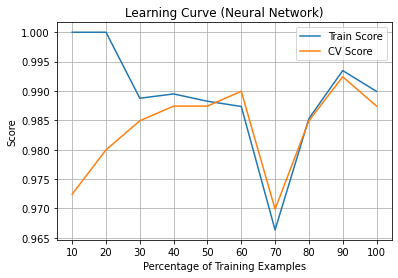

In [107]:
# Learning Curve
classifier_neural_network_learning_rp = mlp_rp
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning_rp, X_RP_train, y_RP_train, 
                                              train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('./images/bc_neural_network_learning_curve_rp.png')
plt.show()

# MLP on LDA data

In [108]:
start_time = time.time()
mlp_lda = MLPClassifier(
    max_iter=1000,
    alpha=0.1,
    activation='logistic',
    solver='adam',
    random_state=42
)

mlp_lda.fit(X_LDA_train, y_LDA_train)

mlp_predict_lda = mlp_lda.predict(X_LDA_test)
mlp_predict_proba_lda = mlp_lda.predict_proba(X_LDA_test)[:, 1]
end_time = time.time()
time_infer = end_time-start_time

print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_LDA_test, mlp_predict_lda) * 100))
print('MLP AUC: {:.2f}%'.format(roc_auc_score(y_LDA_test, mlp_predict_proba_lda) * 100))
print('MLP Classification report:\n\n', classification_report(y_LDA_test, mlp_predict_lda))
#print('MLP Training set score: {:.2f}%'.format(mlp.score(X_LDA_train, y_LDA_train) * 100))
#print('MLP Testing set score: {:.2f}%'.format(mlp.score(X_LDA_test, y_LDA_test) * 100))
print("Inference Time:",time_infer)

MLP Accuracy: 97.66%
MLP AUC: 99.91%
MLP Classification report:

               precision    recall  f1-score   support

           0       0.97      0.99      0.98       108
           1       0.98      0.95      0.97        63

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

Inference Time: 0.4624037742614746


The model used is MultiLayerPerceptronClassification
The accuracy is 0.9766081871345029
The precision is 0.9836065573770492
The recall is 0.9523809523809523
The F1-Score is 0.9677419354838709
The Matthews correlation coefficient is 0.9497047862559932
The ROC-AUC Score is 0.9715608465608465


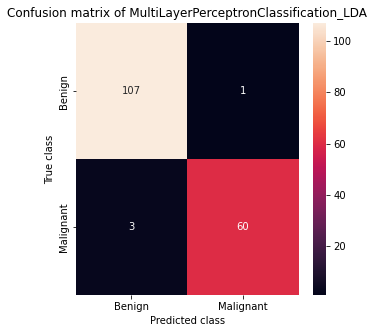

In [109]:
y_pred_mlp_lda = mlp_predict_lda
evaluation_metrics(y_LDA_test,y_pred_mlp_lda,"MultiLayerPerceptronClassification")
plot_confusion_matrix(y_LDA_test,y_pred_mlp_lda,"MultiLayerPerceptronClassification_LDA","breastcancer")

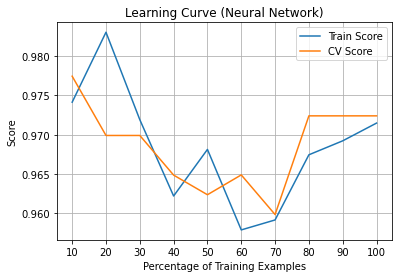

In [110]:
# Learning Curve
classifier_neural_network_learning_lda = mlp_lda
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning_lda, X_LDA_train, y_LDA_train, 
                                              train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('./images/bc_neural_network_learning_curve_lda.png')
plt.show()

# Neural Networks with Clustering (i.e Clusters as new features to dimensionally reduced data)

# K-Means

In [112]:
k = 2
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit_transform(X)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



array([[2.16113609, 1.16066614],
       [1.46285089, 0.64126907],
       [1.67643003, 0.44121137],
       ...,
       [1.27554275, 0.6164495 ],
       [2.33584906, 1.2126729 ],
       [0.79564013, 1.89756133]])

In [113]:
X_KMeans = np.append(X, k_means_clustering.fit_transform(X), 1)
X_KMeans_train, X_KMeans_test, y_KMeans_train, y_KMeans_test = train_test_split(X_KMeans, y, test_size=0.3, random_state=42)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [114]:
start_time = time.time()
mlp_pca_kmeans = MLPClassifier(
    max_iter=1000,
    alpha=0.1,
    activation='logistic',
    solver='adam',
    random_state=42
)

mlp_pca_kmeans.fit(X_KMeans_train, y_KMeans_train)

mlp_predict_pca_kmeans = mlp_pca_kmeans.predict(X_KMeans_test)
mlp_predict_proba_pca_kmeans = mlp_pca_kmeans.predict_proba(X_KMeans_test)[:, 1]
end_time = time.time()
time_infer = end_time-start_time

print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_KMeans_test, mlp_predict_pca_kmeans) * 100))
print('MLP AUC: {:.2f}%'.format(roc_auc_score(y_KMeans_test, mlp_predict_proba_pca_kmeans) * 100))
print('MLP Classification report:\n\n', classification_report(y_KMeans_test, mlp_predict_pca_kmeans))
#print('MLP Training set score: {:.2f}%'.format(mlp.score(X_KMeans_train, y_KMeans_train) * 100))
#print('MLP Testing set score: {:.2f}%'.format(mlp.score(X_KMeans_test, y_KMeans_test) * 100))
print("Inference Time:",time_infer)

MLP Accuracy: 100.00%
MLP AUC: 100.00%
MLP Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        63

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171

Inference Time: 0.8431317806243896


The model used is MultiLayerPerceptronClassification
The accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1-Score is 1.0
The Matthews correlation coefficient is 1.0
The ROC-AUC Score is 1.0


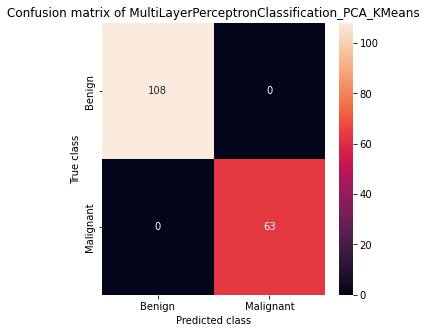

In [115]:
y_pred_mlp_pca_kmeans = mlp_predict_pca_kmeans
evaluation_metrics(y_KMeans_test,y_pred_mlp_pca_kmeans,"MultiLayerPerceptronClassification")
plot_confusion_matrix(y_KMeans_test,y_pred_mlp_pca_kmeans,"MultiLayerPerceptronClassification_PCA_KMeans","breastcancer")

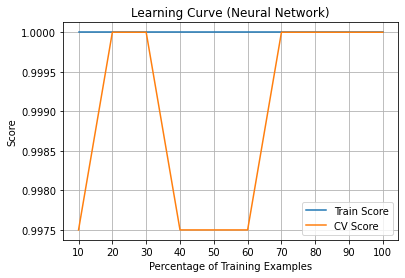

In [116]:
# Learning Curve
classifier_neural_network_learning_pca_kmeans = mlp_pca_kmeans
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning_pca_kmeans, X_KMeans_train, 
                                              y_KMeans_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('./images/bc_neural_network_learning_curve_pca_kmeans.png')
plt.show()

# EM

In [119]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)
gmm.predict_proba(X)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [120]:
X_GMM = np.append(X, gmm.predict_proba(X), 1)
X_GMM_train, X_GMM_test, y_GMM_train, y_GMM_test = train_test_split(X_GMM, y, test_size=0.3, random_state=42)

/Users/sravya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [121]:
start_time = time.time()
mlp_pca_em = MLPClassifier(
    max_iter=1000,
    alpha=0.1,
    activation='logistic',
    solver='adam',
    random_state=42
)

mlp_pca_em.fit(X_GMM_train, y_GMM_train)

mlp_predict_pca_em = mlp_pca_em.predict(X_GMM_test)
mlp_predict_proba_pca_em = mlp_pca_em.predict_proba(X_GMM_test)[:, 1]
end_time = time.time()
time_infer = end_time-start_time

print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_GMM_test, mlp_predict_pca_em) * 100))
print('MLP AUC: {:.2f}%'.format(roc_auc_score(y_GMM_test, mlp_predict_proba_pca_em) * 100))
print('MLP Classification report:\n\n', classification_report(y_GMM_test, mlp_predict_pca_em))
#print('MLP Training set score: {:.2f}%'.format(mlp.score(X_GMM_train, y_GMM_train) * 100))
#print('MLP Testing set score: {:.2f}%'.format(mlp.score(X_GMM_test, y_GMM_test) * 100))
print("Inference Time:",time_infer)

MLP Accuracy: 100.00%
MLP AUC: 100.00%
MLP Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        63

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171

Inference Time: 0.6999661922454834


The model used is MultiLayerPerceptronClassification
The accuracy is 1.0
The precision is 1.0
The recall is 1.0
The F1-Score is 1.0
The Matthews correlation coefficient is 1.0
The ROC-AUC Score is 1.0


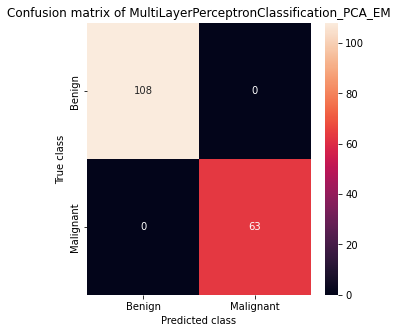

In [122]:
y_pred_mlp_pca_em = mlp_predict_pca_em
evaluation_metrics(y_GMM_test,y_pred_mlp_pca_em,"MultiLayerPerceptronClassification")
plot_confusion_matrix(y_GMM_test,y_pred_mlp_pca_em,"MultiLayerPerceptronClassification_PCA_EM","breastcancer")

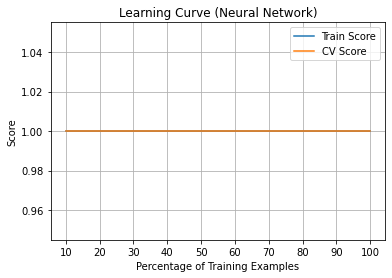

In [123]:
# Learning Curve
classifier_neural_network_learning_pca_em = mlp_pca_em
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning_pca_em, X_GMM_train, 
                                              y_GMM_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('./images/bc_neural_network_learning_curve_pca_em.png')
plt.show()